### ***MULTI-CLASS CLASSIFICATION PROBLEM***
MỤC TIÊU CỦA BÀI NÀY LÀ PHÂN LOẠI 1 ĐIỂM THUỘC CLUSTER NÀO (0,1,2,3)

tensor([[ 4.4471, -0.8496],
        [ 5.4521,  3.1119],
        [-8.9062, -8.8638],
        [-8.9192,  5.8501],
        [-5.8510,  6.0754]]) tensor([1, 1, 2, 3, 3])


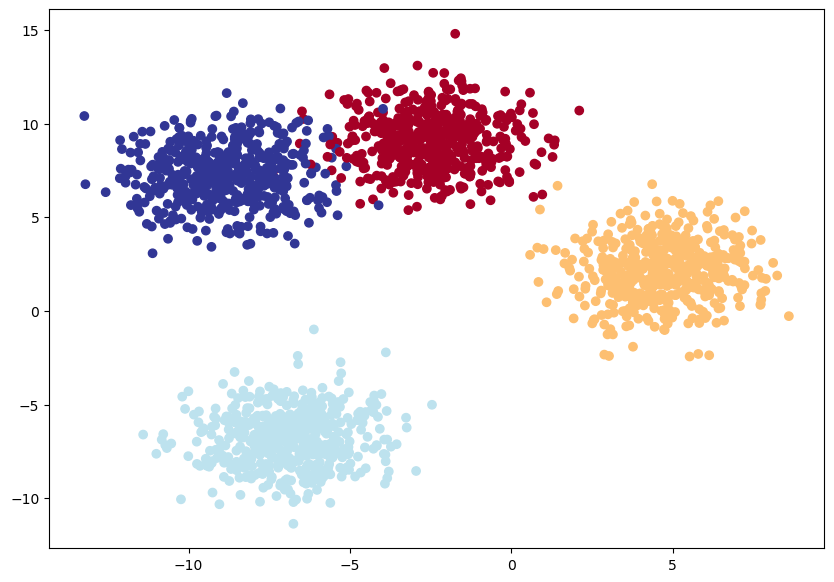

In [189]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=2000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [190]:
device = torch.device('cuda:0')

In [191]:
import torch
from torch import nn
class Multi_class(nn.Module) :
    def __init__(self, inp, outp, neuron):
        super().__init__()
        self.Layers = nn.Sequential(
            nn.Linear(inp,neuron),
            nn.ReLU(),
            nn.Linear(neuron, neuron),
            nn.ReLU(),
            nn.Linear(neuron, outp)
        )
    def forward(self, X) :
        return self.Layers(X)
model_0 = Multi_class(2,4,8)
model_0.to(device)

Multi_class(
  (Layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

CÁC HÀM CHUYỂN ĐỔI

In [192]:
def device_switch(*tensor, device) :
    if device == 'cpu' :
        return [t.to('cpu') for t in tensor]
    elif device == 'gpu' :
        return [t.to(torch.device('cuda:0')) for t in tensor] 
def get_dtype(*tensor) :
    return [[t.dtype for t in tensor], [t.device for t in tensor]]
def dtype_switch(*tensor, dtype) :
    if dtype=='float32':
        return [t.type(torch.float) for t in tensor]
def get_shape(*tensor) :
    return [t.shape for t in tensor]

In [193]:
X_train, y_train, X_test, y_test = device_switch(X_train, y_train, X_test, y_test, device = 'gpu')

In [194]:
get_dtype(X_train, y_train, X_test, y_test)

[[torch.float32, torch.int64, torch.float32, torch.int64],
 [device(type='cuda', index=0),
  device(type='cuda', index=0),
  device(type='cuda', index=0),
  device(type='cuda', index=0)]]

In [195]:
get_shape(X_train, y_train, X_test, y_test)

[torch.Size([1600, 2]),
 torch.Size([1600]),
 torch.Size([400, 2]),
 torch.Size([400])]

##### ***BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH***


In [196]:
# KHI HUẤN LUYỆN XONG CHẠY CODE NÀY ĐỂ KIỂM TRA DỰ ĐOÁN
softmax = torch.softmax(model_0(X_train), dim=1)
softmax[:10], softmax.argmax(1), y_train[:10].T
print(f"{accuracy_pts(softmax, y_train)}/{len(y_train)}")

388/1600


In [197]:
from torch.utils.data import TensorDataset, DataLoader
bs = 40
train_DL = DataLoader(TensorDataset(X_train, y_train), batch_size=bs)
test_DL = DataLoader(TensorDataset(X_test, y_test), batch_size=bs)
for X,y in train_DL :
    print(X.shape, y.shape)
    break

torch.Size([40, 2]) torch.Size([40])


In [198]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)

In [199]:
preds = model_0(X_train)
y_train.squeeze_()
y_train = y_train.type(torch.long)
loss_fn(preds, y_train)

tensor(1.6783, device='cuda:0', grad_fn=<NllLossBackward0>)

In [200]:
def accuracy_pts(logits, ground_y) :
    y_pred = torch.softmax(logits, dim = 1).argmax(1)
    return (y_pred == ground_y).sum().item()

In [201]:
def train_loop(model, dataloader, loss_fn, optim) :
    model.train()
    for X,y in dataloader :
        logits = model(X)
        y = y.squeeze().type(torch.long)
        loss = loss_fn(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
def test_loop(model, dataloader, loss_fn) :
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.inference_mode() :
        for X,y in dataloader :
            logits = model(X)
            y = y.squeeze().type(torch.long)
            total_loss+=loss_fn(logits, y).item()
            total_correct += accuracy_pts(logits, y)
    print(f"trung binh sai so: {total_loss/len(dataloader)}")
    print(f"do chinh xac : {total_correct/4}/%")
    

In [202]:
epochs = 10
for epoch in range(epochs) :
    train_loop(model_0, train_DL, loss_fn, optim) 
    test_loop(model_0, test_DL, loss_fn)

trung binh sai so: 1.0613915503025055
do chinh xac : 30.75/%
trung binh sai so: 0.9275788784027099
do chinh xac : 65.25/%
trung binh sai so: 0.8074185848236084
do chinh xac : 80.25/%
trung binh sai so: 0.6610004961490631
do chinh xac : 94.0/%
trung binh sai so: 0.5210964888334274
do chinh xac : 94.75/%
trung binh sai so: 0.38932604193687437
do chinh xac : 96.5/%
trung binh sai so: 0.2631009936332703
do chinh xac : 98.5/%
trung binh sai so: 0.17492405772209169
do chinh xac : 99.0/%
trung binh sai so: 0.12686709836125373
do chinh xac : 99.5/%
trung binh sai so: 0.10007000491023063
do chinh xac : 99.5/%
